<a href="https://colab.research.google.com/github/smojumder018/SUPREME/blob/main/Fourier_Neural_Operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operator Learing - Fourier Neural Operator

Solutions of PDEs are operators that act as mappings between function spaces. They take initial conditions, boundary conditions, and source terms as inputs and yield the PDE solution as output. For instance, in fluid dynamics, the solution operator can compute the flow profile at a specific future time (e.g. $T = 1$) given the initial flow and boundary conditions.

\\


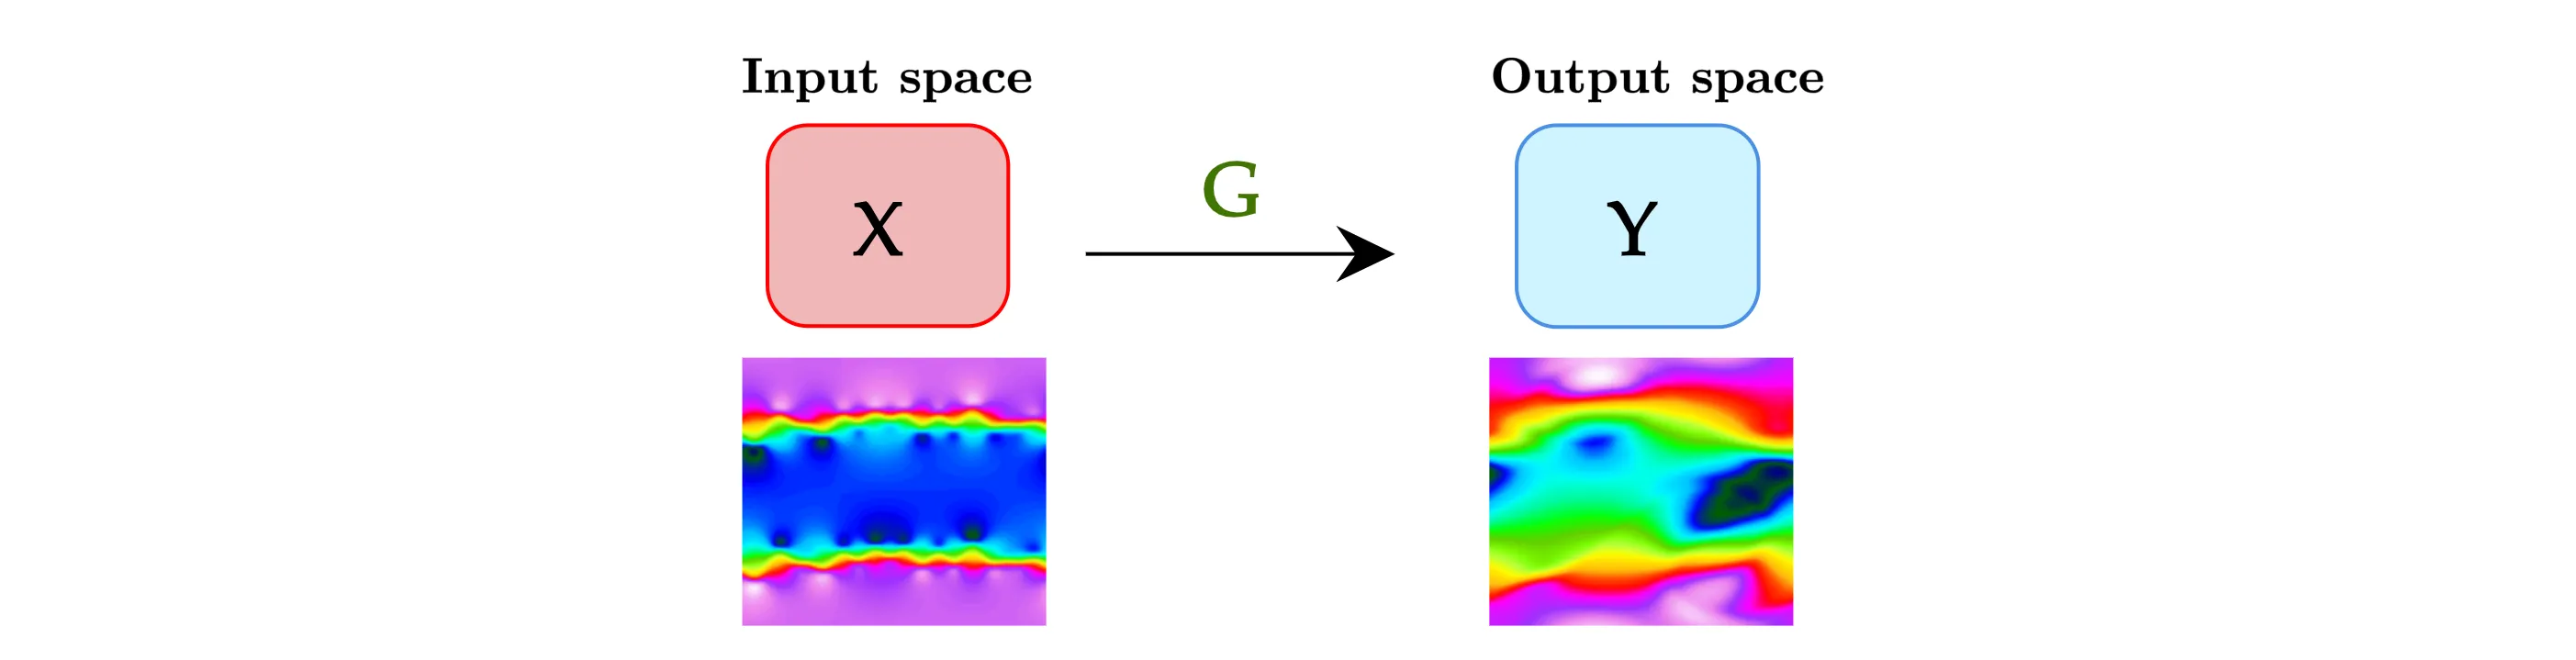

In **operator learning**, models are tasked with handling functions as inputs and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

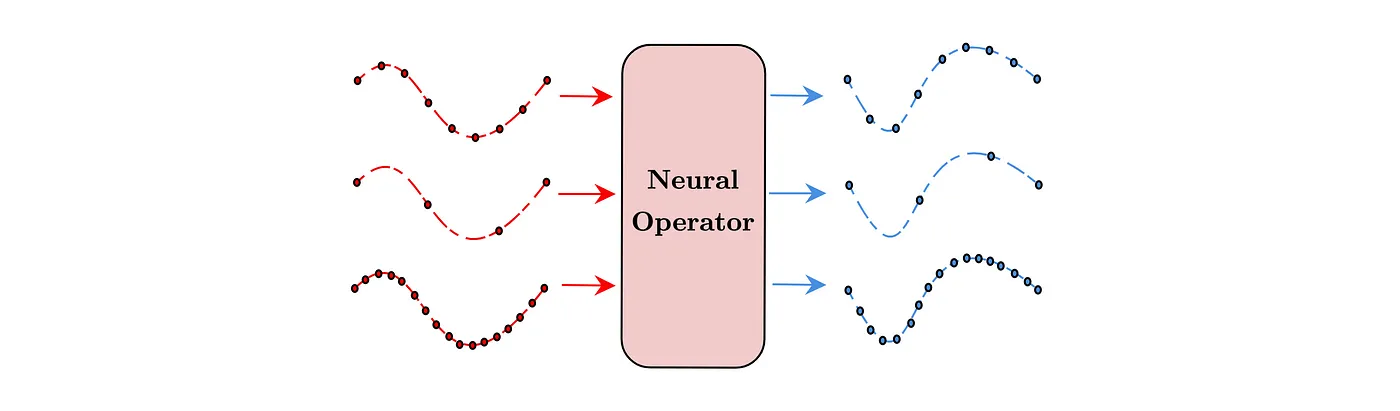



## Fourier Neural Operator (FNO)

- Introduced in the paper [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).
- FNO is formulated as an **iterative architecture**
- FNO uses **convolutions** parametrized in the **frequency domain** (**global** operations)
- FNO uses **skip connections** to enchance the training

First layer is the **lifting layer** (in the channel dimension, increases the number of channels), while the last layer is the **projection layer** (reduces the number of channels.

\\

You can read the blog at [FNO blog](https://zongyi-li.github.io/blog/2020/fourier-pde/).


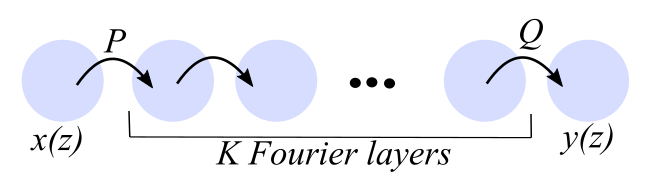

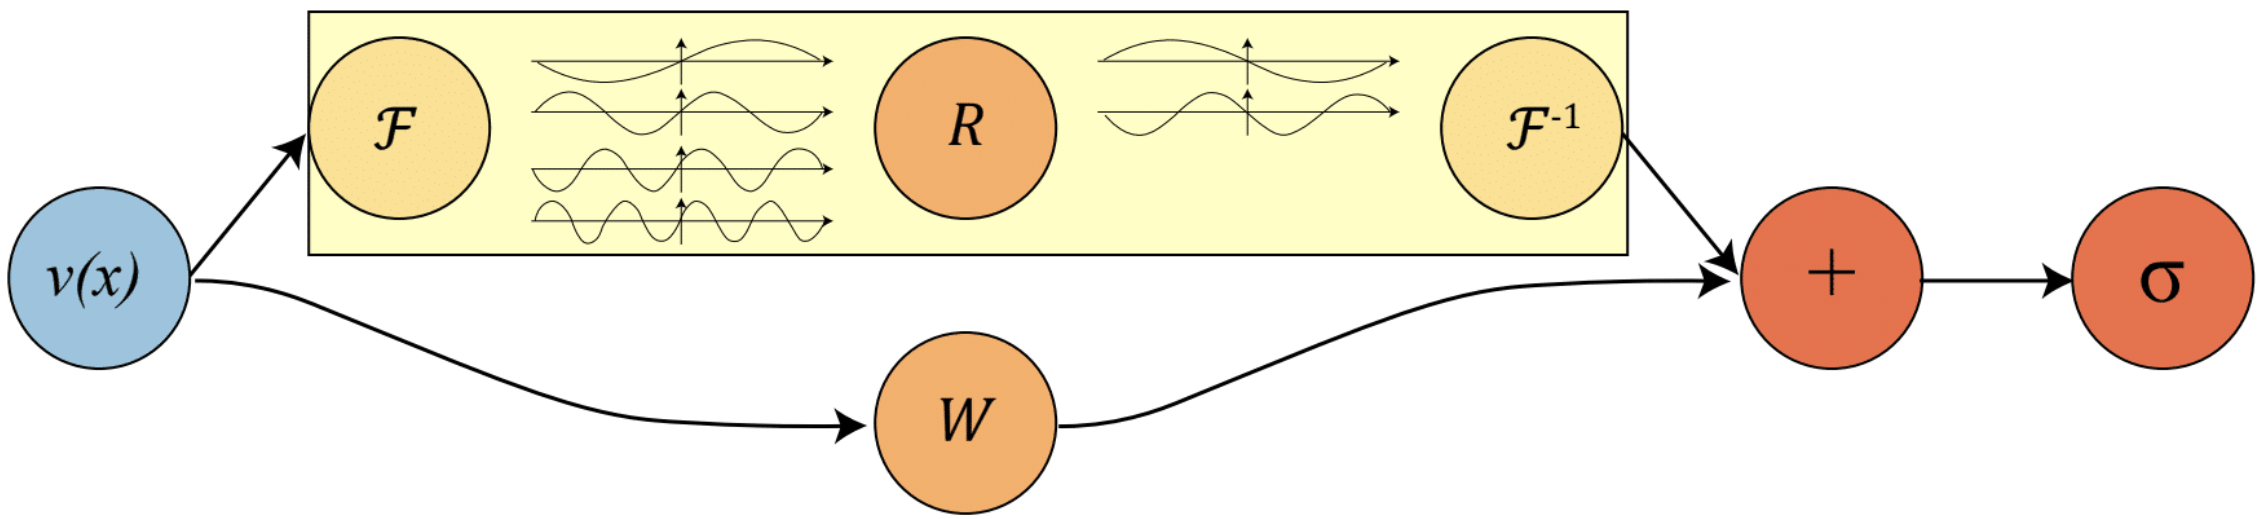

The Fourier layer just consists of three steps:

1. Fourier transform (using FFT)

2. Linear transform on the lower Fourier modes

3. Inverse Fourier transform

In [54]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt


**Mish** is a smooth, self-regularized activation function defined as:

$$
\text{Mish}(x) = x \cdot \tanh(\ln(1 + e^x)
$$

- Smooth and differentiable everywhere
- Keeps small negative values instead of cutting them off like ReLU
- Encourages better gradient flow during backpropagation
- May generalize better than ReLU in deep networks

###  Comparison with Other Activations

| Activation | Expression | Pros | Cons |
|------------|------------|------|------|
| **ReLU** | $\max(0, x)$ | Fast and simple | Zero gradient for $x < 0$ |
| **Sigmoid** | $\frac{1}{1 + e^{-x}}$ | Smooth and bounded | Saturates, vanishing gradients |
| **Mish** | $x \cdot \tanh(\ln(1 + e^x))$ | Smooth, retains negatives, good gradient flow | Slightly slower to compute |




In [55]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


\\

- We define Fourier layer in 1d (or spectral convolution)

In [56]:
# Spectral (or Fourier) layer in 1d

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer:
        - Applies FFT to input
        - Applies learned complex weights to lower Fourier modes
        - Applies inverse FFT to return to spatial domain
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to use

        # Initialize complex-valued weights scaled by input/output size
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Performs complex multiplication of input Fourier coeffs with learned weights
    def compl_mul1d(self, input, weights):
        # input: [batch, in_channels, x]
        # weights: [in_channels, out_channels, x]
        # output: [batch, out_channels, x]
        return torch.einsum("bix,iox->box", input, weights) #batched matrix multiplication using Einstein summation using weights

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]


        # Apply real-to-complex FFT over last dimension - forward and reverse done together
        x_ft = torch.fft.rfft(x)


        # Allocate zero tensor to hold transformed Fourier modes
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-1) // 2 + 1,  # initializes the output of the Fourier transform
            device=x.device, dtype=torch.cfloat
        )

        # Apply complex-valued learned weights to first few Fourier modes - filling zeros matrix
        out_ft[:, :, :self.modes1] = self.compl_mul1d(
            x_ft[:, :, :self.modes1], self.weights1
        )


        # Transform back to real space using inverse FFT
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


\\

- The *FNO1d* uses *SpectralConv1d* as its crucial part.

In [57]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes                       # Number of Fourier modes
        self.width = width                        # Width of feature dimension
        self.padding = 1                          # pad the domain if input is non-periodic

        # Input projection: maps 2-channel input (u0(x), x) to width
        self.linear_p = nn.Linear(2, self.width)                             #feature lifting

        # 3 Fourier spectral layers
        #layer that performs computation in the frequency domain instead of the spatial domain
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)

        # 1x1 Conv layers for local interactions / residuals
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        # Final projection to output dimension
        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh() #Activation function


    # Combines Fourier layer and pointwise conv layer, followed by activation
    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    # Applies a linear layer followed by activation
    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):

        # Lift input to higher
        x = self.linear_p(x) # -> [batch, grid, width]
        x = x.permute(0, 2, 1) # -> [batch, width, grid] for conv1d compatibility


        # Apply three Fourier layers with local residuals
        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

       # Restore original shape - to match convolution layer
        x = x.permute(0, 2, 1)

        # Project back to 1D output (e.g. u(x, t))
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


## Example

We will solve Allen-Cahn equation:

## $u_t = \Delta u - ϵ^2 u (u^2 - 1),\quad u\in\mathbb{R}×\mathbb{R_{>0}}$

Operator that we wish to learn is

## $\mathcal{G}: u(\cdot, t = 0) \mapsto  u(\cdot, t = 1)$

Note that the data is generated for you (see the files *AC_data_input.npy* and *AC_data_output.npy*).

## Manual Seeds
Setting these seeds ensures **reproducibility** in your experiments. Random processes in training (like weight initialization or data shuffling) can lead to slightly different results each time you run your code — unless you fix the seed.



- `torch.manual_seed(0)`  
  Sets the seed for PyTorch's random number generator.  
  Affects:
  - Weight initialization
  - DataLoader shuffling
  - `torch.rand`, `torch.randn`, etc.

- `np.random.seed(0)`  
  Sets the seed for NumPy's random number generator.  
  Affects:
  - `np.random.rand`, `np.random.randn`, `np.random.choice`, etc.


###  Why

Without fixed seeds:
- Two runs of the same model can give slightly different results
- Debugging and comparison become unreliable

With fixed seeds:
- Your code becomes **deterministic**
- You can replicate results exactly
- Other people (or future-you) get the same outcome



In [58]:
torch.manual_seed(0)
np.random.seed(0)

In [59]:
n_train = 100 # number of training samples

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
project_path = '/content/drive/MyDrive/SUPREME/FTOP/'
os.chdir(project_path)

x_data = torch.from_numpy(np.load("AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("AC_data_output.npy")).type(torch.float32)

# Swap columns in x_data - data processing step
# x_data[:,:,0] = x (position), x_data[:,:,1] = u0
temporary_tensor = torch.clone(x_data[:, :, 0])
x_data[:, :, 0] = x_data[:, :, 1]
x_data[:, :, 1] = temporary_tensor


# Split the dataset into training and testing sets
input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10  #For mini batch traiing


training_set = DataLoader(
    TensorDataset(input_function_train, output_function_train),
    batch_size=batch_size,
    shuffle=True          # Shuffle to improve training generalization
)

testing_set = DataLoader(
    TensorDataset(input_function_test, output_function_test),
    batch_size=batch_size,
    shuffle=False        #Dont need to shuffle testing data since its used for validation
)

Mounted at /content/drive


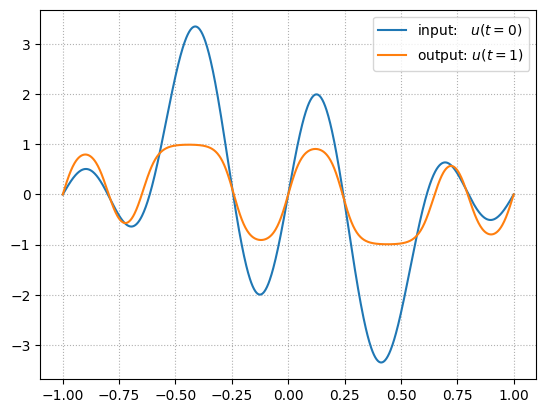

In [60]:
id_sample = 31     # Choose a specific sample to visualize

plt.plot(np.linspace(-1,1,input_function_train.shape[1]),input_function_train[id_sample,:,0], label = "input:   $u(t = 0)$")
plt.plot(np.linspace(-1,1,input_function_train.shape[1]),output_function_train[id_sample,:], label = "output: $u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

In [61]:
learning_rate = 0.001
epochs = 10
step_size = 50           # Step interval to reduce learning rate
gamma = 0.5              # Learning rate decay factor

In [62]:
modes = 16                 # Number of Fourier modes
width = 64                 # Width of feature channels
fno = FNO1d(modes, width)  # Initialize model


## Training

##  L2

L2 - used to measure how close your model’s predictions are to the true outputs.


MSE is used during training

$$
\text{Relative L2 error} = 100 \times \sqrt{\frac{\text{MSE}}{\text{mean}(y_{\text{true}}^2)}}
$$





| Metric          | Used In   | Meaning                         |
|-----------------|-----------|----------------------------------|
| **MSE**         | Training  | L2-based loss (squared error)   |
| **Relative L2** | Testing   | % error relative to signal size |


- MSE is used for L2 loss in training.
- Relative L2 error is used in testing to evaluate accuracy relative to the signal



In [63]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler- reduces LR by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss() #Loss function

freq_print = 1

#Training Loop
for epoch in range(epochs):
    train_mse = 0.0         # Track training loss
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)  # Forward pass, remove last dim
        loss_f = l(output_pred_batch, output_batch)      # Compute MSE loss
        loss_f.backward()                                # Backpropagation
        optimizer.step()                                 # Update weights
        train_mse += loss_f.item()
    train_mse /= len(training_set)                       # Average training loss

    scheduler.step()           # Update learning rate

    with torch.no_grad():      # Turn off gradient tracking
        fno.eval()             # Set model to evaluation mode
        test_relative_l2 = 0.0

        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)

            # Compute relative L2 error in percentage
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)    # Average error

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)

#L2 is large due to magnitude of variance - but R^2 score shows the variance is minimal

######### Epoch: 0  ######### Train Loss: 0.3041863638907671  ######### Relative L2 Test Norm: 38.97848881615533
######### Epoch: 1  ######### Train Loss: 0.06348589062690735  ######### Relative L2 Test Norm: 24.926396550072564
######### Epoch: 2  ######### Train Loss: 0.03617080110125244  ######### Relative L2 Test Norm: 16.515777174631754
######### Epoch: 3  ######### Train Loss: 0.016960195265710354  ######### Relative L2 Test Norm: 13.224721394644844
######### Epoch: 4  ######### Train Loss: 0.01366209341213107  ######### Relative L2 Test Norm: 11.714262056350709
######### Epoch: 5  ######### Train Loss: 0.008291577105410397  ######### Relative L2 Test Norm: 10.766488817003038
######### Epoch: 6  ######### Train Loss: 0.007858113618567586  ######### Relative L2 Test Norm: 10.443437634574043
######### Epoch: 7  ######### Train Loss: 0.007652460713870823  ######### Relative L2 Test Norm: 9.87248609330919
######### Epoch: 8  ######### Train Loss: 0.005044722999446094  ######### Relati

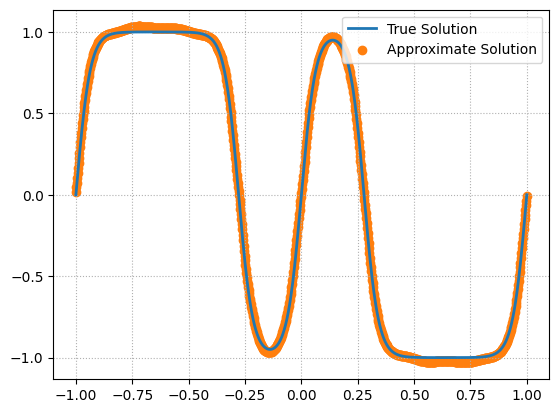

In [64]:
idx_data = 32
input_function_test_n = input_function_test[idx_data].unsqueeze(0)
output_function_test_n = output_function_test[idx_data].unsqueeze(0)
output_function_test_pred_n = fno(input_function_test_n)

s = output_function_test_n.shape[-1]
X = np.linspace(-1, 1, s)

y_true = output_function_test_n.squeeze().detach().cpu().numpy()           # shape (1001,)
y_pred = output_function_test_pred_n.squeeze(-1).detach().cpu().numpy()     # squeeze last dim, shape (1001,)

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(X, y_true, label="True Solution", c="C0", lw=2)
plt.scatter(X, y_pred, label="Approximate Solution", c="C1")
plt.legend()
plt.show()


In [65]:
import torch.nn.functional as F
from sklearn.metrics import r2_score

# Your predicted and true output tensors
y_true = output_function_test_n
y_pred = output_function_test_pred_n.squeeze(-1)

# MSE loss in PyTorch
mse_loss = F.mse_loss(y_pred, y_true)
print("MSE Loss:", mse_loss.item())

# R^2 score in sklearn
y_true_np = y_true.squeeze().detach().cpu().numpy()
y_pred_np = y_pred.squeeze().detach().cpu().numpy()

r2 = r2_score(y_true_np, y_pred_np)
print("R^2 Score:", r2)


MSE Loss: 0.0003456695703789592
R^2 Score: 0.9995366930961609
